In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [4]:
file = pd.read_csv(r'Dataset/Dataset_13.05.2020_11.18am_1.csv')
tweets = np.asarray(file['Tweet'].copy())
targets = np.asarray(file['Is_Unreliable'].copy())
tweet_embeddings = np.load(r'Dataset/Tweet_Embeddings_Word2Vec_13.05.2020_2.41pm_1.npy', allow_pickle=True)
print(tweet_embeddings.shape)
print(tweet_embeddings[0].shape)
X = list()
for tweet in tweet_embeddings:
    embeddings = np.mean(tweet, axis=0, dtype=np.float64)
    X.append(embeddings)
X = np.asarray(X)
print(X.shape)
print(X.dtype)

y = targets
print(y.shape)
print(y.dtype)

(560,)
(15, 300)
(560, 300)
float64
(560,)
int64


In [189]:
# print(y)
# y[y == 1] = -1
# y[y == 0] = 1
# y[y == -1] = 0
# print(y)

In [5]:
class AE(nn.Module):

    def __init__(self, hidden_size=100):
        super(AE, self).__init__()
        self.fc1 = nn.Linear(300, hidden_size)  # 6*6 from image dimension
        self.fc2 = nn.Linear(hidden_size, 300)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# net = AE()
# print(net)

def train_AE(model, X_train, y_train, X_test, y_test, epochs=100, to_print=False, print_interval=100):
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    train_mse_list, test_1_mse_list, test_0_mse_list = list(), list(), list()
    # enumerate epochs
    for epoch in tqdm(range(epochs)):
        # clear the gradients
        optimizer.zero_grad()
        X_train = torch.from_numpy(X_train).float()
        X_test = torch.from_numpy(X_test).float()
        output = model(X_train)
#         print(X_train)
#         print(output)
        train_loss = criterion(output, X_train)
        train_loss.backward()
        optimizer.step()
        if to_print and epoch%print_interval == 0:
            print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, train_loss))
        
        train_preds = model(X_train)
        X_train = X_train.numpy()
        train_preds = train_preds.detach().numpy()
        test_preds = model(X_test)
        X_test = X_test.numpy()
        test_preds = test_preds.detach().numpy()
        train_mse = np.mean(np.square(X_train - train_preds), axis=1)
        test_1_mse = np.mean(np.square(X_test[y_test == 1] - test_preds[y_test == 1]), axis=1)
        test_0_mse = np.mean(np.square(X_test[y_test == 0] - test_preds[y_test == 0]), axis=1)
        train_mse_list.append(train_mse), test_1_mse_list.append(test_1_mse), test_0_mse_list.append(test_0_mse)
#         print('Train:', train_mse, ' Test (1_class):', test_1_mse, ' Test (0_class):', test_0_mse)
        
    return model, (train_mse_list, test_1_mse_list, test_0_mse_list)

def predict_AE(model, X_train, X_test, threshold, above_thres_class=0):
    
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    train_out = model(X_train)
    X_train = X_train.numpy()
    train_out = train_out.detach().numpy()
    test_out = model(X_test)
    X_test = X_test.numpy()
    test_out = test_out.detach().numpy()
    train_mse = np.mean(np.square(X_train - train_out), axis=1)
    test_mse = np.mean(np.square(X_test - test_out), axis=1)
    
    train_preds, test_preds = np.empty((train_mse.shape[0])), np.empty((test_mse.shape[0]))
    train_preds[train_mse > threshold] = above_thres_class
    train_preds[train_mse <= threshold] = (above_thres_class+1)%2
    test_preds[test_mse > threshold] = above_thres_class
    test_preds[test_mse <= threshold] = (above_thres_class+1)%2
        
    return (train_preds, test_preds)

In [110]:
# from scipy import stats

# stats.describe(X)

In [154]:
# model = AE()
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer.zero_grad()
# X_trial = X.copy()
# X_trial = torch.from_numpy(X_trial).float()
# output = model(X_trial)
# output = output.detach().numpy()

# stats.describe(output)

In [161]:
# np.square(X_trial[0] - output[0])
# output[0]
# X_trial[0]

In [204]:
# # Autoencoder on class=1 as training data

# kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# a_score, f_score, p_score, r_score, roc_score = list(), list(), list(), list(), list()
# t_a_score, t_f_score, t_p_score, t_r_score, t_roc_score = list(), list(), list(), list(), list()

# for train_index, test_index in kfold.split(X[y == 1], y[y == 1]):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     X_train, y_train = X[y == 1][train_index].copy(), y[y == 1][train_index].copy()
#     X_test, y_test = np.concatenate((X[y == 1][test_index].copy(), X[y == 0].copy())), np.concatenate((y[y == 1][test_index].copy(), y[y == 0].copy()))
    
#     model = AE(hidden_size=100).to(device)
#     n_epochs = 200
#     model, (train_mse_list, test_1_mse_list, test_0_mse_list) = train_AE(model, X_train, y_train, X_test, y_test, to_print=True, epochs=n_epochs, print_interval=n_epochs/10)
    
#     var_for_plot = -(n_epochs-50)
#     # train_mse_list, test_1_mse_list, test_0_mse_list = np.mean(np.asarray(train_mse_list), axis=1), np.mean(np.asarray(test_1_mse_list), axis=1), np.mean(np.asarray(test_0_mse_list), axis=1)
#     plt.plot(np.arange(len(train_mse_list))[var_for_plot:], np.mean(np.asarray(train_mse_list), axis=1)[var_for_plot:], label='train_mse_list', color='blue')
#     plt.plot(np.arange(len(test_1_mse_list))[var_for_plot:], np.mean(np.asarray(test_1_mse_list), axis=1)[var_for_plot:], label='test_1_mse_list', color='red')
#     plt.plot(np.arange(len(test_0_mse_list))[var_for_plot:], np.mean(np.asarray(test_0_mse_list), axis=1)[var_for_plot:], label='test_0_mse_list', color='yellow')
#     plt.show()
    
#     best_f = 0
#     train_preds, preds = np.empty((X_train.shape[0])), np.empty((X_test.shape[0]))
#     for th in np.arange(0.0005, 0.0030, 0.0001):
#         (tr_preds, te_preds) = predict_AE(model, X_train, X_test, threshold=th, above_thres_class=0)
#         if (f1_score(y_test, te_preds) > best_f):
#             best_f = f1_score(y_test, te_preds)
#             train_preds = tr_preds
#             preds = te_preds
    
#     t_a_score.append(accuracy_score(y_train, train_preds))
#     t_f_score.append(f1_score(y_train, train_preds)), t_p_score.append(precision_score(y_train, train_preds)), t_r_score.append(recall_score(y_train, train_preds))
#     a_score.append(accuracy_score(y_test, preds))
#     f_score.append(f1_score(y_test, preds)), p_score.append(precision_score(y_test, preds)), r_score.append(recall_score(y_test, preds))
#     print('Train: ', t_a_score[-1], t_f_score[-1], t_p_score[-1], t_r_score[-1])
#     print('Test : ', a_score[-1], f_score[-1], p_score[-1], r_score[-1])
    
# print('')
# print('Train: ', sum(t_a_score)/len(t_a_score), sum(t_f_score)/len(t_f_score), sum(t_p_score)/len(t_p_score), sum(t_r_score)/len(t_r_score))
# print('Test : ', sum(a_score)/len(a_score), sum(f_score)/len(f_score), sum(p_score)/len(p_score), sum(r_score)/len(r_score))

 23%|██▎       | 23/100 [00:00<00:00, 89.29it/s]

epoch : 1/100, train_loss = 0.008131
epoch : 11/100, train_loss = 0.002301
epoch : 21/100, train_loss = 0.001843


 57%|█████▋    | 57/100 [00:00<00:00, 116.33it/s]

epoch : 31/100, train_loss = 0.001558
epoch : 41/100, train_loss = 0.001338
epoch : 51/100, train_loss = 0.001185
epoch : 61/100, train_loss = 0.001048


100%|██████████| 100/100 [00:00<00:00, 147.65it/s]

epoch : 71/100, train_loss = 0.000955
epoch : 81/100, train_loss = 0.000899
epoch : 91/100, train_loss = 0.000842


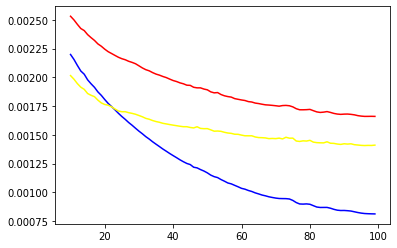

 16%|█▌        | 16/100 [00:00<00:00, 154.14it/s]

Train:  1.0 1.0 1.0 1.0
Test :  0.2620320855614973 0.4051724137931034 0.25405405405405407 1.0
epoch : 1/100, train_loss = 0.008171
epoch : 11/100, train_loss = 0.002241
epoch : 21/100, train_loss = 0.001789
epoch : 31/100, train_loss = 0.001522


 71%|███████   | 71/100 [00:00<00:00, 168.92it/s]

epoch : 41/100, train_loss = 0.001369
epoch : 51/100, train_loss = 0.001213
epoch : 61/100, train_loss = 0.001088
epoch : 71/100, train_loss = 0.000998


100%|██████████| 100/100 [00:00<00:00, 165.50it/s]


epoch : 81/100, train_loss = 0.000931
epoch : 91/100, train_loss = 0.000882


 13%|█▎        | 13/100 [00:00<00:00, 119.59it/s]

Train:  1.0 1.0 1.0 1.0
Test :  0.24932975871313673 0.39914163090128757 0.24932975871313673 1.0
epoch : 1/100, train_loss = 0.008130
epoch : 11/100, train_loss = 0.002328


 27%|██▋       | 27/100 [00:00<00:00, 79.25it/s] 

epoch : 21/100, train_loss = 0.001882
epoch : 31/100, train_loss = 0.001603


 55%|█████▌    | 55/100 [00:00<00:00, 99.00it/s]

epoch : 41/100, train_loss = 0.001405
epoch : 51/100, train_loss = 0.001271
epoch : 61/100, train_loss = 0.001167


100%|██████████| 100/100 [00:00<00:00, 111.09it/s]

epoch : 71/100, train_loss = 0.001109
epoch : 81/100, train_loss = 0.001038
epoch : 91/100, train_loss = 0.000989


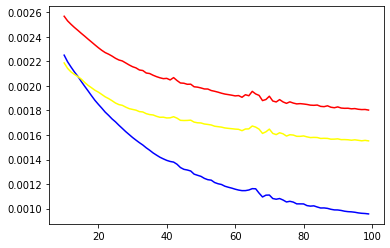

Train:  1.0 1.0 1.0 1.0
Test :  0.2707774798927614 0.4008810572687224 0.2520775623268698 0.978494623655914

Train:  1.0 1.0 1.0 1.0
Test :  0.2607131080557985 0.4017317006543712 0.25182045836468686 0.992831541218638


In [10]:
# Autoencoder on class=0 as training data (class=0 has been changed to class=1 for calculating f1_score, precision, etc.)

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

a_score, f_score, p_score, r_score, roc_score = list(), list(), list(), list(), list()
t_a_score, t_f_score, t_p_score, t_r_score, t_roc_score = list(), list(), list(), list(), list()

for train_index, test_index in kfold.split(X[y == 0], y[y == 0]):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    X_train, y_train = X[y == 0][train_index].copy(), y[y == 0][train_index].copy()
    X_test, y_test = np.concatenate((X[y == 0][test_index].copy(), X[y == 1].copy())), np.concatenate((y[y == 0][test_index].copy(), y[y == 1].copy()))
#     print(y_train.shape, sum(y_train))
#     print(y_test.shape, sum(y_test))
    y_train[y_train == 1] = -1
    y_test[y_test == 1] = -1
    y_train[y_train == 0] = 1
    y_test[y_test == 0] = 1
    y_train[y_train == -1] = 0
    y_test[y_test == -1] = 0
#     print(y_train.shape, sum(y_train))
#     print(y_test.shape, sum(y_test))
    
    model = AE(hidden_size=100).to(device)
#     print(model)
    n_epochs = 100
    model, (train_mse_list, test_1_mse_list, test_0_mse_list) = train_AE(model, X_train, y_train, X_test, y_test, epochs=n_epochs, to_print=True, print_interval=n_epochs/10)
    
    var_for_plot = -(n_epochs-10)
    # train_mse_list, test_1_mse_list, test_0_mse_list = np.mean(np.asarray(train_mse_list), axis=1), np.mean(np.asarray(test_1_mse_list), axis=1), np.mean(np.asarray(test_0_mse_list), axis=1)
    plt.plot(np.arange(len(train_mse_list))[var_for_plot:], np.mean(np.asarray(train_mse_list), axis=1)[var_for_plot:], label='train_mse_list', color='blue')
    plt.plot(np.arange(len(test_1_mse_list))[var_for_plot:], np.mean(np.asarray(test_1_mse_list), axis=1)[var_for_plot:], label='test_1_mse_list', color='red')
    plt.plot(np.arange(len(test_0_mse_list))[var_for_plot:], np.mean(np.asarray(test_0_mse_list), axis=1)[var_for_plot:], label='test_0_mse_list', color='yellow')
#     plt.savefig('1.png')
    plt.show()
    
    best_f = 0
    train_preds, preds = np.empty((X_train.shape[0])), np.empty((X_test.shape[0]))
    for th in np.arange(0.0001, 0.0100, 0.0001):
        (tr_preds, te_preds) = predict_AE(model, X_train, X_test, threshold=th, above_thres_class=0)
        if (f1_score(y_test, te_preds) > best_f):
            best_f = f1_score(y_test, te_preds)
            train_preds = tr_preds
            preds = te_preds

#     best_f = 0
#     train_preds, preds = np.empty((X_train.shape[0])), np.empty((X_test.shape[0]))
#     for h_size in np.arange(1, 300, 5):
#         for ep in np.arange(1, 200, 5):
#             model = AE(hidden_size=h_size).to(device)
#             # print(model)
#             n_epochs = ep
#             model, (train_mse_list, test_1_mse_list, test_0_mse_list) = train_AE(model, X_train, y_train, X_test, y_test, to_print=False, epochs=n_epochs, print_interval=n_epochs/10)

#             var_for_plot = -(n_epochs-10)
#             # train_mse_list, test_1_mse_list, test_0_mse_list = np.mean(np.asarray(train_mse_list), axis=1), np.mean(np.asarray(test_1_mse_list), axis=1), np.mean(np.asarray(test_0_mse_list), axis=1)
#             # plt.plot(np.arange(len(train_mse_list))[var_for_plot:], np.mean(np.asarray(train_mse_list), axis=1)[var_for_plot:], label='train_mse_list', color='blue')
#             # plt.plot(np.arange(len(test_1_mse_list))[var_for_plot:], np.mean(np.asarray(test_1_mse_list), axis=1)[var_for_plot:], label='test_1_mse_list', color='red')
#             # plt.plot(np.arange(len(test_0_mse_list))[var_for_plot:], np.mean(np.asarray(test_0_mse_list), axis=1)[var_for_plot:], label='test_0_mse_list', color='yellow')
#             # plt.show()

#             for th in np.arange(0.0001, 0.0100, 0.0001):
#                 (tr_preds, te_preds) = predict_AE(model, X_train, X_test, threshold=th, above_thres_class=0)
#                 if (f1_score(y_test, te_preds) > best_f):
#                     best_f = f1_score(y_test, te_preds)
#                     train_preds = tr_preds
#                     preds = te_preds
    
    t_a_score.append(accuracy_score(y_train, train_preds))
    t_f_score.append(f1_score(y_train, train_preds)), t_p_score.append(precision_score(y_train, train_preds)), t_r_score.append(recall_score(y_train, train_preds))
    a_score.append(accuracy_score(y_test, preds))
    f_score.append(f1_score(y_test, preds)), p_score.append(precision_score(y_test, preds)), r_score.append(recall_score(y_test, preds))
    print('Train: ', t_a_score[-1], t_f_score[-1], t_p_score[-1], t_r_score[-1])
    print('Test : ', a_score[-1], f_score[-1], p_score[-1], r_score[-1])
    
print('')
print('Train: ', sum(t_a_score)/len(t_a_score), sum(t_f_score)/len(t_f_score), sum(t_p_score)/len(t_p_score), sum(t_r_score)/len(t_r_score))
print('Test : ', sum(a_score)/len(a_score), sum(f_score)/len(f_score), sum(p_score)/len(p_score), sum(r_score)/len(r_score))

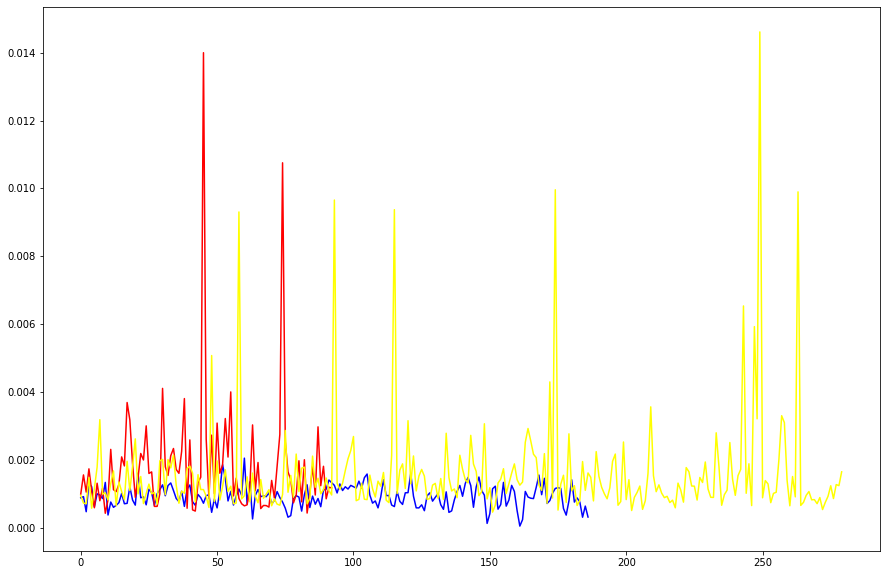

In [9]:
plt.figure(figsize=(15, 10))
plt.plot(np.arange(train_mse_list[-1].shape[0]), train_mse_list[10], label='train_mse_list', color='blue')
# plt.show()
plt.plot(np.arange(test_1_mse_list[-1].shape[0]), test_1_mse_list[10], label='test_1_mse_list', color='red')
# plt.show()
plt.plot(np.arange(test_0_mse_list[-1].shape[0]), test_0_mse_list[10], label='test_0_mse_list', color='yellow')
# plt.savefig('1.png')
plt.show()

plt.figure(figsize=(15, 10))
plt.plot(np.arange(train_mse_list[-1].shape[0]), train_mse_list[-1], label='train_mse_list', color='blue')
# plt.show()
plt.plot(np.arange(test_1_mse_list[-1].shape[0]), test_1_mse_list[-1], label='test_1_mse_list', color='red')
# plt.show()
plt.plot(np.arange(test_0_mse_list[-1].shape[0]), test_0_mse_list[-1], label='test_0_mse_list', color='yellow')
# plt.savefig('2.png')
plt.show()

In [198]:
# np.asarray(train_mse_list[-2])

In [200]:
plt.plot(np.arange(len(train_mse_list))[:], np.mean(np.asarray(train_mse_list), axis=1)[:], label='train_mse_list', color='blue')
plt.plot(np.arange(len(test_1_mse_list))[:], np.mean(np.asarray(test_1_mse_list), axis=1)[:], label='test_1_mse_list', color='red')
plt.plot(np.arange(len(test_0_mse_list))[:], np.mean(np.asarray(test_0_mse_list), axis=1)[:], label='test_0_mse_list', color='yellow')
plt.show()

In [169]:
# y_trial = y.copy()
# y_trial[y_trial == 1] = -1
# y_trial[y_trial == 0] = 1
# y_trial[y_trial == -1] = 0
# print(y_trial)